Running Through EAZY Py
This is an individual testing notebook, testing one template suite at a time.

catalogue_prepare.ipynb can be used to prepare a catalogue for testing.


In [22]:

%matplotlib inline

import os
import glob
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
from astropy.utils.exceptions import AstropyWarning
import eazy.hdf5
import time
import importlib
import sys
import eazy
import astropy.stats

np.seterr(all='ignore')
warnings.simplefilter('ignore', category=AstropyWarning)
print('EAZYCODE = '+ str(os.getenv('EAZYCODE')) + '\n')

print(time.ctime() + '\n')

print(sys.version + '\n')

for module in ['numpy', 'scipy', 'matplotlib','astropy','eazy']:
    mod = importlib.import_module(module)
    print('{0:>20} : {1}'.format(module, mod.__version__))

EAZYCODE = None

Sun Jun 23 15:42:23 2024

3.10.13 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:24:38) [MSC v.1916 64 bit (AMD64)]

               numpy : 1.22.3
               scipy : 1.7.3
          matplotlib : 3.8.0
             astropy : 5.3.4
                eazy : 0.6.8


Basic Settings Cell, can find more in depth changes further down

In [23]:
# Load ZFOURGE catalogue from local drive
test_title = 'test_3' # title of the test, eg. 1,2, A, B, Initial.
field = 'cdfs' #'cdfs', 'cosmos', or 'uds'

# Choose ID key for the catalogue
# A key designates what type of test you want to occur
id_key = 'normal' # normal, high or low

# Directories for key, name keys anything, it is just to keep track of any complex object choices made in catalogue_prepare.ipynb
id_key_dict = {'normal': 'inputs/alternate_catalogues/cdfs.range.(0, -1).cat',
      'fraction_bin_10': f'inputs/alternate_catalogues/{field}.fraction.bin10.0.cat',
   'luminosity_bin_10' : f'inputs/alternate_catalogues/{field}.luminosity.bin10.0.cat'}

# AGN templates allocation
loop_number = 1 # what loop you are on, however in the test ipy this is not used
agn_sed = [] # AGN templates to be added
use_galaxy_templates = True # set to True to use galaxy templates as well

In [24]:
# finding/creating the output directories

# Directories
if not os.path.isdir(f'outputs/{field}/{test_title}'):
    os.makedirs(f'outputs/{field}/{test_title}')

# Where to Save number data
output_directory = f'outputs/{field}/{test_title}/{field}_{test_title}_{id_key}_{agn_sed}_{use_galaxy_templates}' # output directory for images
key_data_file = f'outputs/{field}/{test_title}/{test_title}_data.csv'
headings = ['id_key', 'zstep', 'loop_number', 'agn_templates', 'galaxy templates', 'total_obj', 'mean_agn_frac', 'spec_count', 'outlier_count', 'nmad_val']

key_data = pd.DataFrame(columns=headings)
if not os.path.isfile(key_data_file):
    key_data.to_csv(key_data_file, index=False)


AGN Data Analysis

In [25]:
# Read the catalogue
os.getcwd()

main_cat = pd.read_csv(id_key_dict[id_key]) # get the catalogue for the id_key
main_cat.to_csv('inputs/eazy_test.cat', index=False) # create a new catalogue, allows for change to be made in this cell


main = pd.read_csv('inputs/eazy_test.cat', sep=" ", comment="#", header=None, skipinitialspace=True) # opening cut cat, and adjusting it
headers = pd.read_csv('inputs/eazy_test.cat', sep=" ", header=None, nrows=1).iloc[0]
headers = headers[1:]
main.columns = headers

total_count = len(main) # all objects in the range

In [26]:
# Plot of % influence from AGN on each object

agn_per_dir = f'inputs/{field}_agn_frac.txt' # file with AGN fractions for each object, prepared in catalogue_prepare.ipynb
all_bayes = pd.read_csv(agn_per_dir, sep="\s+", comment='#')

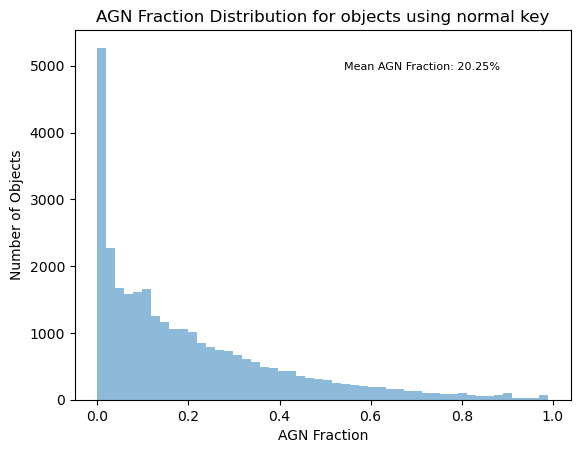

In [71]:
main = pd.merge(main, all_bayes, on='id', how='left') # AGN fraction for each object
mean_frac = np.mean(main['bayes.agn.fracAGN'])
positive_agn = main[main['bayes.agn.fracAGN'] > 0]

plt.clf()
plt.hist(main['bayes.agn.fracAGN'], bins=50, alpha=0.5, label='AGN Fraction')

plt.xlabel('AGN Fraction')
plt.ylabel('Number of Objects')
plt.title(f'AGN Fraction Distribution for objects using {id_key} key')
plt.text(0.7, 0.9, f'Mean AGN Fraction: {mean_frac:.2%}', fontsize=8, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.savefig(f'outputs/{field}/{test_title}/agn_frac_{field}_{id_key}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

Loading AGN Templates Function

In [28]:
# Load any templates from the AGN template library

temp_param = 'templates/eazy_v1.3.spectra.param' # basic parameter file, no agn templates
last_id = 9 # last id in the parameter file
empty_param = 'templates/eazy_v1.3_empty.param' # empty parameter file

agn_param = 'templates/eazy_v1.3_AGN.param' # parameter file with agn templates

# opening the parameter files, and reading the contents
with open(temp_param) as f:
    original_galaxy = f.read()

with open(empty_param) as f:
    original_empty = f.read()

agn_dir = 'templates/hlsp_agnsedatlas_observed/' # dir with all agn templates
agn_temp_all = os.listdir(agn_dir)
def agn_template_loader(templates, use_galaxy_templates=False):
    """
    Function to load AGN templates to the parameter file
    templates: list of templates to be added
    use_galaxy_templates: set to True to use galaxy templates as well
    """
    if use_galaxy_templates:
      copy = original_galaxy
      no_of_templates = len(templates)
      if no_of_templates == 0:
        open(agn_param, 'w').write(copy)
        print('No AGN templates added, just using EAZY galaxy templates')
        return
      for i in range(no_of_templates):
        id = last_id + i
        copy = copy + f'\n{id}   {agn_dir}{agn_temp_all[templates[i]]}   1.0 0 1.0    '
      open(agn_param, 'w').write(copy)
      print(f'AGN templates added to the parameter file {agn_param}, {last_id} galaxy templates used')
      return
    else:
      copy = original_empty
      no_of_templates = len(templates)
      if no_of_templates == 0:
        open(agn_param, 'w').write(copy)
        print('No AGN templates added, no templates used')
        return
      for i in range(no_of_templates):
        id = 0 + i
        copy = copy + f'\n{id}   {agn_dir}{agn_temp_all[templates[i]]}   1.0 0 1.0    '
      open(agn_param, 'w').write(copy)
      print(f'AGN templates added to the parameter file {agn_param}, no galaxy templates used')
      return

Running EAZY, some paramaters can be changed here, look to the base.param file to adjust more

In [29]:
# EAZY parameters

# following files should be in the same dir as the project
param_file = 'base.param' #base parameter file, does not include all information
translate_file = glob.glob(f'zfourge/{field}/eazy/{field}.*.translate')

agn_template_loader(agn_sed, use_galaxy_templates=use_galaxy_templates) # loads the chosen AGN templates to the parameter file

params = {} # setting field specific parameters
params['Z_STEP'] = 0.005 # redshift step, defines the precision of each fit, 0.005 default

#inputs
params['TEMPLATES_FILE'] = 'templates/eazy_v1.3_AGN.param' # parameter file containing which templates will be used
params['CACHE_FILE'] = f'zfourge/{field}/{field}.tempfilt'
params['CATALOG_FILE'] = f'inputs/eazy_test.cat' # for cut catalogue created in the earlier cell

#outputs
params['MAIN_OUTPUT_FILE'] = output_directory # output directory set earlier


No AGN templates added, just using EAZY galaxy templates


Initialize eazy.photoz.PhotoZ object

In [30]:
# Run EAZY with parameters

self = eazy.photoz.PhotoZ(param_file=param_file, translate_file=translate_file[0], zeropoint_file=None,
                         params=params, load_prior=True, load_products=False)

Read default param file: base.param
Read CATALOG_FILE: inputs/eazy_test.cat
   >>> NOBJ = 30910
f_IRAC_80 e_IRAC_80 ( 21): IRAC/irac_tr4_2004-08-09.dat
f_IRAC_58 e_IRAC_58 ( 20): IRAC/irac_tr3_2004-08-09.dat
f_IRAC_45 e_IRAC_45 ( 19): IRAC/irac_tr2_2004-08-09.dat
f_IRAC_36 e_IRAC_36 ( 18): IRAC/irac_tr1_2004-08-09.dat
f_Ks e_Ks (255): FOURSTAR/Ks_cam_optics_sky.txt
f_KsHI e_KsHI (269): VLT/hawki_k_ETC.dat
f_J1 e_J1 (249): FOURSTAR/J1_cam_optics_sky.txt
f_J2 e_J2 (250): FOURSTAR/J2_cam_optics_sky.txt
f_J3 e_J3 (251): FOURSTAR/J3_cam_optics_sky.txt
f_Hs e_Hs (254): FOURSTAR/Hshort_cam_optics_sky.txt
f_Hl e_Hl (253): FOURSTAR/Hlong_cam_optics_sky.txt
f_U e_U (103): ESO/vimos_u.res
f_B e_B (  1): hst/ACS_update_sep07/wfc_f435w_t77.dat
f_V e_V (  4): hst/ACS_update_sep07/wfc_f606w_t77.dat
f_R e_R (260): ESO/VIMOS/R.dat
f_I e_I (  5): hst/ACS_update_sep07/wfc_f775w_t77.dat
f_Z e_Z (  7): hst/ACS_update_sep07/wfc_f850lp_t77.dat
f_F125W e_F125W (203): hst/wfc3/IR/f125w.dat
f_F140W e_F140W (204

100%|██████████| 9/9 [01:48<00:00, 12.08s/it] 


Template   0: eazy_v1.1_sed1.dat (NZ=1).
Template   1: eazy_v1.1_sed2.dat (NZ=1).
Template   2: eazy_v1.1_sed3.dat (NZ=1).
Template   3: eazy_v1.1_sed4.dat (NZ=1).
Template   4: eazy_v1.1_sed5.dat (NZ=1).
Template   5: eazy_v1.1_sed6.dat (NZ=1).
Template   6: eazy_v1.1_sed7.dat (NZ=1).
Template   7: c09_del_8.6_z_0.019_chab_age09.40_av2.0.dat (NZ=1).
Template   8: erb2010_highEW.dat (NZ=1).
Process templates: 109.761 s


479it [00:12, 36.97it/s]


Iterative zeropoint corrections

Iteration:  0


100%|██████████| 479/479 [03:50<00:00,  2.08it/s]


Compute best fits
fit_best: 5.6 s (n_proc=2,  NOBJ=29433)
Fit 237.5 s (n_proc=8, NOBJ=29668)
Iterative correction - zeropoint / template
Iteration:  1


100%|██████████| 479/479 [03:32<00:00,  2.25it/s]


Compute best fits
fit_best: 5.5 s (n_proc=2,  NOBJ=29445)
Fit 219.1 s (n_proc=8, NOBJ=29668)
Iterative correction - zeropoint / template
Iteration:  2


100%|██████████| 479/479 [03:31<00:00,  2.27it/s]


Compute best fits
fit_best: 5.5 s (n_proc=2,  NOBJ=29446)
Fit 218.1 s (n_proc=8, NOBJ=29668)
Iterative correction - zeropoint / template


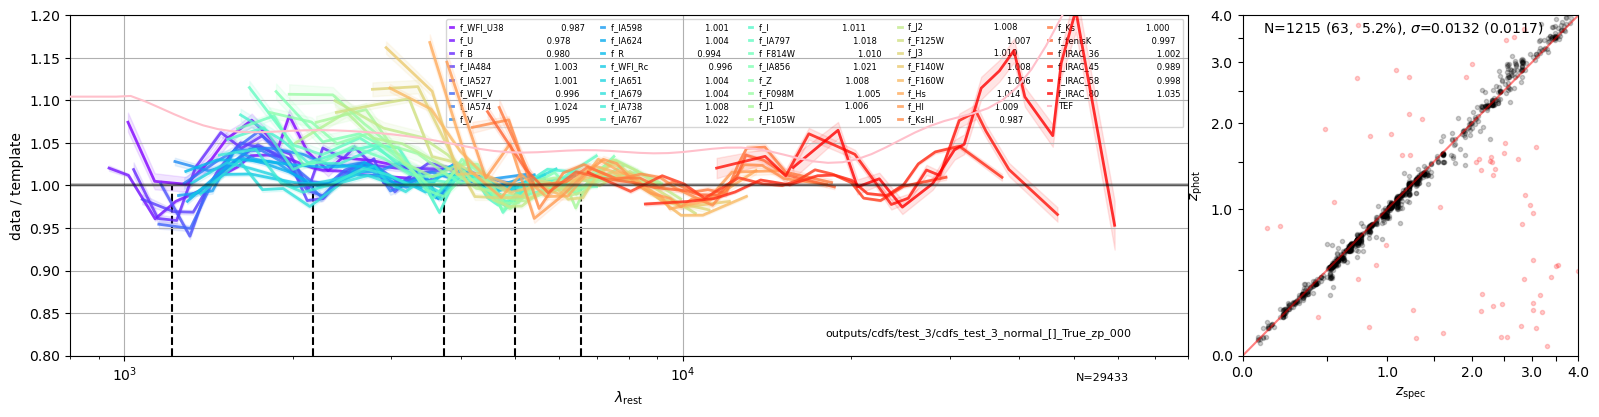

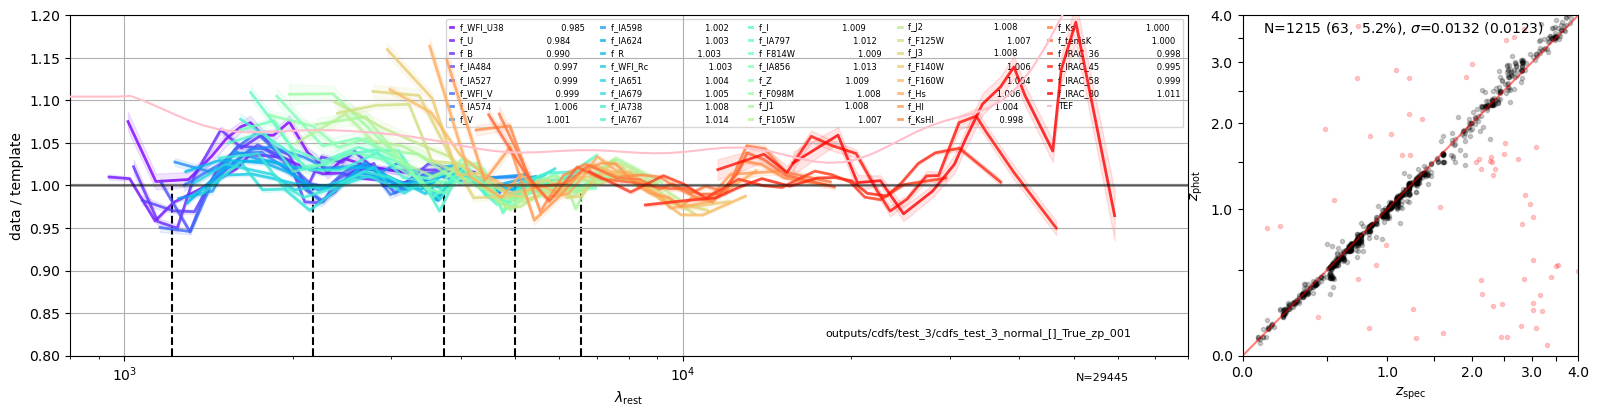

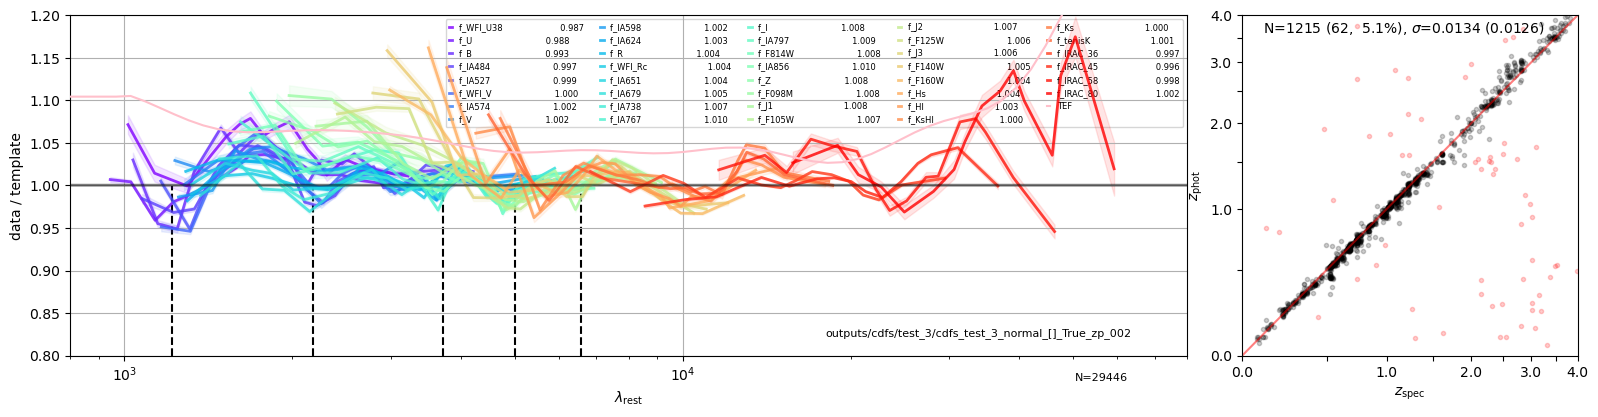

In [31]:
# Iterative Zero-point corrections

NITER = 3 # no. of iterations
NBIN = np.minimum(self.NOBJ//100, 180) # no. of bins

for iter in range(NITER):
    print('Iteration: ', iter)

    sn = self.fnu/self.efnu
    clip = (sn > 1).sum(axis=1) > 4 # Generally make this higher to ensure reasonable fits
    self.iterate_zp_templates(idx=self.idx[clip], update_templates=False,
                              update_zeropoints=True, iter=iter, n_proc=8,
                              save_templates=False, error_residuals=False,
                              NBIN=NBIN, get_spatial_offset=False)

Now fit the whole catalog

Set sys_err = 0.00 (positive=True)


100%|██████████| 479/479 [03:40<00:00,  2.18it/s]


Compute best fits
fit_best: 4.8 s (n_proc=3,  NOBJ=30570)
Fit 226.3 s (n_proc=8, NOBJ=30910)


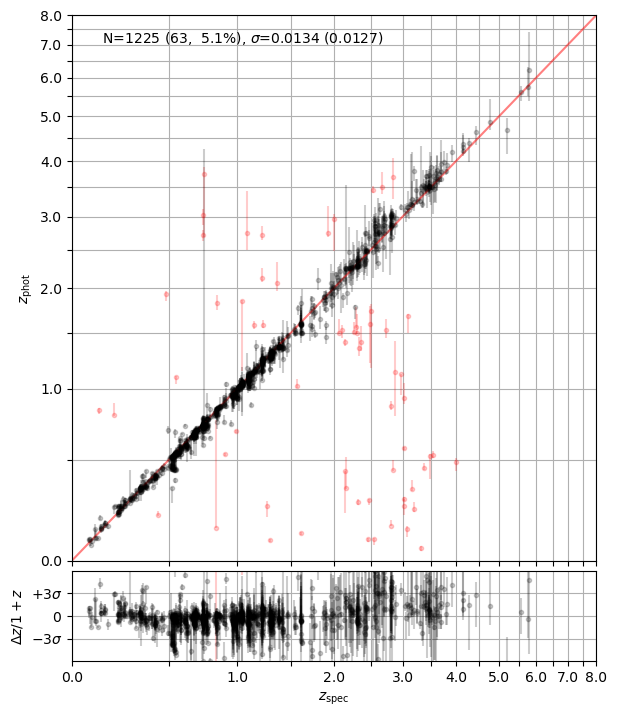

In [32]:
# Turn off error corrections derived above
self.set_sys_err(positive=True)

# Full catalog
sample = np.isfinite(self.ZSPEC)

# fit_parallel renamed to fit_catalog 14 May 2021
self.fit_catalog(self.idx[sample], n_proc=8)

# Show zspec-zphot comparison
fig = self.zphot_zspec(zmax = 8)
fig.savefig(f'outputs/{field}/{test_title}/zphot_zspec_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')

In [33]:
# Derived parameters (z params, RF colors, masses, SFR, etc.)
warnings.simplefilter('ignore', category=RuntimeWarning)
zout, hdu = self.standard_output(simple=False,
                                 rf_pad_width=0.5, rf_max_err=2,
                                 prior=True, beta_prior=True,
                                 absmag_filters=[],
                                 extra_rf_filters=[])

# 'zout' also saved to [MAIN_OUTPUT_FILE].zout.fits

Get best fit coeffs & best redshifts
fit_best: 12.1 s (n_proc=3,  NOBJ=30674)
Get parameters (UBVJ=[153, 154, 155, 161], simple=False)


100%|██████████| 30674/30674 [05:08<00:00, 99.35it/s] 



 Couldn't find template parameters file templates/eazy_v1.3_AGN.param.fits for population synthesis 
 calculations.
            


UVJ Plots

Text(0, 0.5, '$(U-V)_0$')

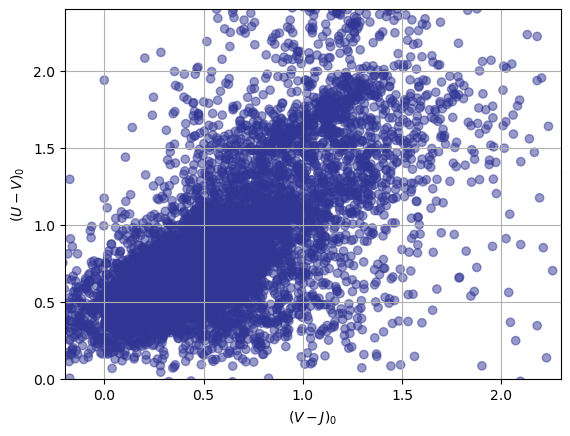

In [34]:
# Show UVJ diagram
uv = -2.5*np.log10(zout['restU']/zout['restV'])
vj = -2.5*np.log10(zout['restV']/zout['restJ'])
ssfr = zout['sfr']/zout['mass']

sel = (zout['z_phot'] > 0.2) & (zout['z_phot'] < 1)
plt.scatter(vj[sel], uv[sel], c=np.log10(ssfr)[sel],
            vmin=-13, vmax=-8, alpha=0.5, cmap='RdYlBu')

plt.xlim(-0.2, 2.3); plt.ylim(0, 2.4); plt.grid()
plt.xlabel(r'$(V-J)_0$'); plt.ylabel(r'$(U-V)_0$')

Produces array showing the Worst Fits

In [35]:
all_zphot_zspec = pd.DataFrame({'id':self.idx, 'zspec':self.ZSPEC, 'zphot':self.zbest})
only_compare = all_zphot_zspec[all_zphot_zspec['zspec'] > 0.005]
only_compare = only_compare.reset_index(drop=False)

red_diff={}
for i in range(len(only_compare)):
    red_diff[i] = abs(only_compare['zphot'][i] - only_compare['zspec'][i])

only_compare['red_diff'] = red_diff
only_compare = only_compare.sort_values(by='red_diff', ascending=False)

Calculating NMAD in bins

In [94]:
#combined = list(zip(self.ZSPEC, self.zbest)) legacy code, want to hold on to it for a bit, see if anything breaks
#filtered = [(x,y) for x, y in combined if x > 0.005 and y > 0.02]
#sorted_filtered = sorted(filtered, key=lambda x: x[0])
#zspec_sorted, zphot_sorted = zip(*sorted_filtered)

main['ZSPEC'] = self.ZSPEC; main['ZPHOT'] = self.zbest # adding zspec and zphot to the agn_frac df
main['chi2'] = self.chi2_best / self.NFILT # adding chi2/N to the main df

#sort main df by zspec
main_red = main[main['ZSPEC'] > 0.005] # filter
main_red = main_red[main_red['ZPHOT'] > 0.02] # filter
main_red = main_red.sort_values(by='ZSPEC') # sort

#sort main df by agn fraction
main_agn = main_red.dropna(subset=['bayes.agn.fracAGN']) # filter
main_agn = main_agn.sort_values(by='bayes.agn.fracAGN') # sort

#total NMAD
dz = (np.array(main_red['ZPHOT']) - np.array(main_red['ZSPEC'])) / (1 + np.array(main_red['ZSPEC']))
total_nmad = astropy.stats.mad_std(dz)
print(f'Total NMAD: {total_nmad}')

#outliers
spec_count = len(dz)
outliers = np.abs(dz) >= 0.15 # 0.15 is catostrophic_outlier in eazy code
outliers_count = sum(outliers)



no_of_bins = 15 # no. of bins

Total NMAD: 0.01342998395512612


Counts: [  5  11   5  26  28  61 101 285 139 229  70 103 100  56   6]
Total: 1225
NMAD: [0.0052960031660661796, 0.02719499387900263, 0.0038081221336973997, 0.013521762562792455, 0.007546819870623097, 0.011044895494261122, 0.010543148655190075, 0.00797476157491259, 0.011701838413964532, 0.012058022438001354, 0.014136031962831364, 0.025271623384016725, 0.05042509464931679, 0.020596146977456996, 0.017860272508119494]


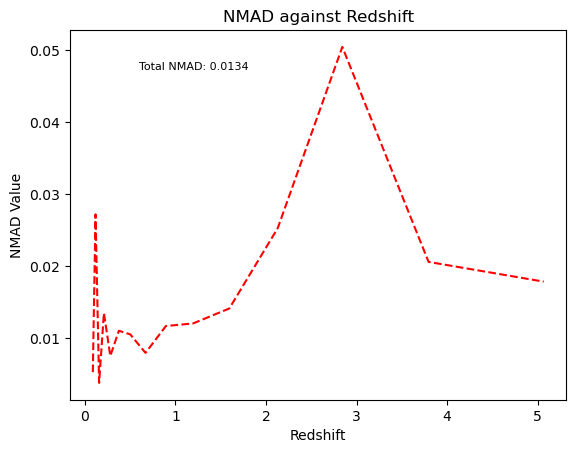

In [83]:

logbins_start = np.log10(min(main_red['ZSPEC'])) # using logarithmic bins
logbins_end = np.log10(max(main_red['ZSPEC'])) + 1e-10 # adding a small value to include the last value
logbins = np.logspace(logbins_start, logbins_end, num=no_of_bins+1)
counts_red, bins_red = np.histogram(main_red['ZSPEC'], bins=logbins)
print(f'Counts: {counts_red}')
print(f'Total: {len(main_red["ZSPEC"])}')
bin_centers_red = (np.array(bins_red[:-1]) + np.array(bins_red[1:])) / 2

last_val = 0 # last val is the first value within a bin (say object 2334), while new val is the last
nmad_val = []
for bin in range(no_of_bins):
    new_val = last_val + counts_red[bin]-1
    zspec_val = main_red['ZSPEC'][last_val:new_val]
    zphot_val = main_red['ZPHOT'][last_val:new_val]
    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
    nmad_val.append(astropy.stats.mad_std(dz))
    last_val = new_val + 1 # adding 1 to skip the last value of the previous bin
print(f'NMAD: {nmad_val}')

plt.clf()
plt.plot(bin_centers_red, nmad_val, 'r--')

plt.text(0.25, 0.9, f'Total NMAD: {total_nmad:.4f}', fontsize=8, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xlabel('Redshift')
plt.ylabel('NMAD Value')


plt.title('NMAD against Redshift')

plt.savefig(f'outputs/{field}/{test_title}/nmadRED_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

Counts: [660 201  87  94  54  21  21  15  12  11  10   3   6  10  11]
NMAD: [0.011234776846961898, 0.011509850634308646, 0.015474166082579616, 0.01945633681750792, 0.01849612299332894, 0.035985443314265515, 0.020626503306641085, 0.01929994949208074, 0.054565157637772956, 0.05290065482519797, 0.0026766338782617687, 0.025592769888535857, 0.25251547647837336, 0.16022867360805768, 0.05142611084712326]


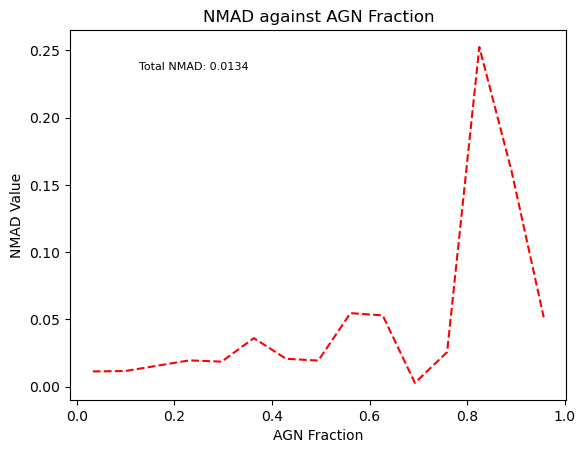

In [91]:
#NMAD against AGN fraction

counts_agn, bins_agn = np.histogram(main_agn['bayes.agn.fracAGN'], bins=no_of_bins)
print(f'Counts: {counts_agn}')
bin_centers_agn = (np.array(bins_agn[:-1]) + np.array(bins_agn[1:])) / 2

last_val = 0 # last val is the first value within a bin (say object 2334), while new val is the last
nmad_agn_val = []
for bin in range(no_of_bins):
    new_val = last_val + counts_agn[bin]-1
    zspec_val = main_agn['ZSPEC'][last_val:new_val]
    zphot_val = main_agn['ZPHOT'][last_val:new_val]
    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
    nmad_agn_val.append(astropy.stats.mad_std(dz))
    last_val = new_val + 1 # adding 1 to skip the last value of the previous bin
print(f'NMAD: {nmad_agn_val}')

plt.clf()
plt.plot(bin_centers_agn, nmad_agn_val, 'r--')

plt.text(0.25, 0.9, f'Total NMAD: {total_nmad:.4f}', fontsize=8, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xlabel('AGN Fraction')
plt.ylabel('NMAD Value')


plt.title('NMAD against AGN Fraction')

plt.savefig(f'outputs/{field}/{test_title}/nmadAGN_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

Outliers: [0.2, 0.45454545454545453, 0.0, 0.34615384615384615, 0.14285714285714285, 0.21311475409836064, 0.38613861386138615, 0.2, 0.31654676258992803, 0.26200873362445415, 0.44285714285714284, 0.5339805825242718, 0.78, 0.5714285714285714, 0.5]


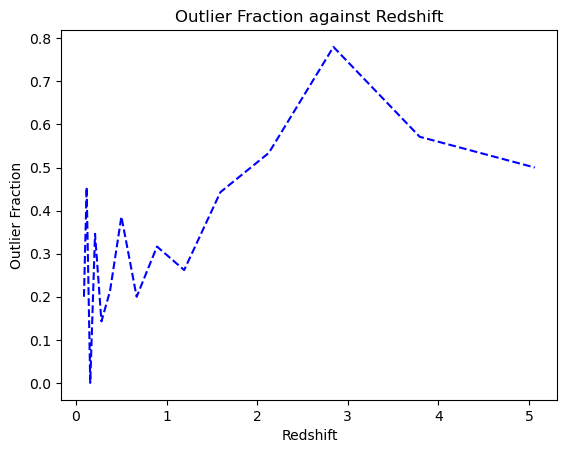

In [92]:
#outlier against Redshift
last_val = 0
outlier_frac_red = []
for bin in range(no_of_bins):
    new_val = last_val + counts_red[bin]-1
    zspec_val = main_red['ZSPEC'][last_val:new_val]
    zphot_val = main_red['ZPHOT'][last_val:new_val]
    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
    outliers_bin = np.abs(dz) >= 0.015
    bin_fraction = sum(outliers_bin) / counts_red[bin]
    outlier_frac_red.append(bin_fraction)
    last_val = new_val + 1
print(f'Outliers: {outlier_frac_red}')

plt.clf()
plt.plot(bin_centers_red, outlier_frac_red, 'b--')

plt.xlabel('Redshift')
plt.ylabel('Outlier Fraction')


plt.title('Outlier Fraction against Redshift')

plt.savefig(f'outputs/{field}/{test_title}/outlierRED_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

Outliers: [0.29393939393939394, 0.29850746268656714, 0.41379310344827586, 0.48936170212765956, 0.42592592592592593, 0.5714285714285714, 0.5714285714285714, 0.4, 0.6666666666666666, 0.5454545454545454, 0.2, 0.6666666666666666, 0.8333333333333334, 0.9, 0.9090909090909091]


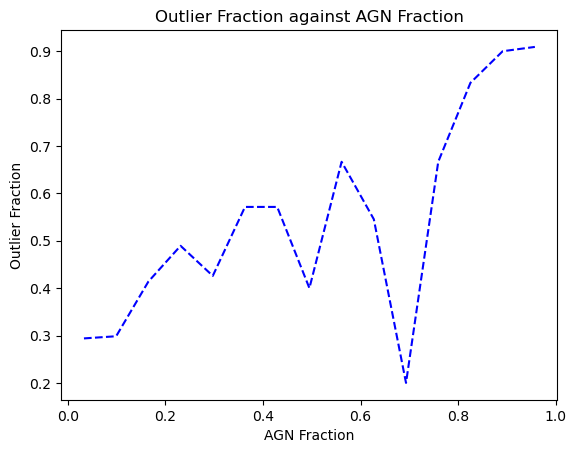

In [93]:
#outlier against AGN fraction

last_val = 0 # last val is the first value within a bin (say object 2334), while new val is the last
outlier_frac_agn = []
for bin in range(no_of_bins):
    new_val = last_val + counts_agn[bin]-1
    zspec_val = main_agn['ZSPEC'][last_val:new_val]
    zphot_val = main_agn['ZPHOT'][last_val:new_val]
    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
    outliers_bin = np.abs(dz) >= 0.015
    bin_fraction = sum(outliers_bin) / counts_agn[bin]
    outlier_frac_agn.append(bin_fraction)
    last_val = new_val + 1 # adding 1 to skip the last value of the previous bin
print(f'Outliers: {outlier_frac_agn}')

plt.clf()
plt.plot(bin_centers_agn, outlier_frac_agn, 'b--')

plt.xlabel('AGN Fraction')
plt.ylabel('Outlier Fraction')


plt.title('Outlier Fraction against AGN Fraction')

plt.savefig(f'outputs/{field}/{test_title}/outlierAGN_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

In [96]:
#chi2 against redshift

last_val = 0 # last val is the first value within a bin (say object 2334), while new val is the last
nmad_agn_val = []
for bin in range(no_of_bins):
    new_val = last_val + counts_agn[bin]-1
    zspec_val = main_chi['ZSPEC'][last_val:new_val]
    zphot_val = main_agn['ZPHOT'][last_val:new_val]
    dz = (np.array(zphot_val) - np.array(zspec_val)) / (1 + np.array(zspec_val))
    nmad_agn_val.append(astropy.stats.mad_std(dz))
    last_val = new_val + 1 # adding 1 to skip the last value of the previous bin
print(f'NMAD: {nmad_agn_val}')

plt.clf()
plt.plot(bin_centers_agn, nmad_agn_val, 'r--')

plt.text(0.25, 0.9, f'Total NMAD: {total_nmad:.4f}', fontsize=8, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.xlabel('AGN Fraction')
plt.ylabel('NMAD Value')


plt.title('NMAD against AGN Fraction')

plt.savefig(f'outputs/{field}/{test_title}/nmadAGN_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

NameError: name 'main_chi' is not defined

Outliers: [0.61668086, 0.58945656, 0.63328916, 0.8962076, 0.94767565, 1.0010209, 1.0551305, 0.9729134, 1.0639778, 1.5282257, 1.3125869, 1.6817797, 2.3789222, 1.1174877, 1.4753497]


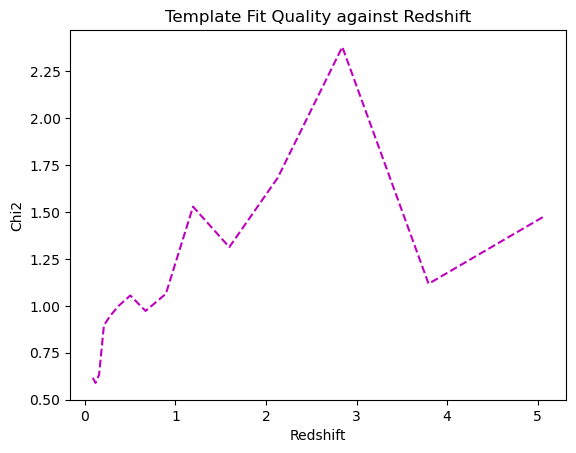

In [101]:
#chi2 against redshift

last_val = 0 # last val is the first value within a bin (say object 2334), while new val is the last
chi2_red = []
for bin in range(no_of_bins):
    new_val = last_val + counts_agn[bin]-1
    chi2_mean = np.median(main_red['chi2'][last_val:new_val])
    chi2_red.append(chi2_mean)
    last_val = new_val + 1
print(f'Fits: {chi2_red}')

plt.clf()
plt.plot(bin_centers_red, chi2_red, 'm--')

plt.xlabel('Redshift')
plt.ylabel('Chi2')


plt.title('Template Fit Quality against Redshift')

plt.savefig(f'outputs/{field}/{test_title}/chi2RED_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

Outliers: [0.61447006, 0.6466197, 0.6726715, 0.7170418, 0.83697116, 0.8006457, 1.1516199, 1.0302492, 1.5121002, 1.9722422, 1.8473926, 4.489678, 1.0523187, 0.8153163, 1.2849104]


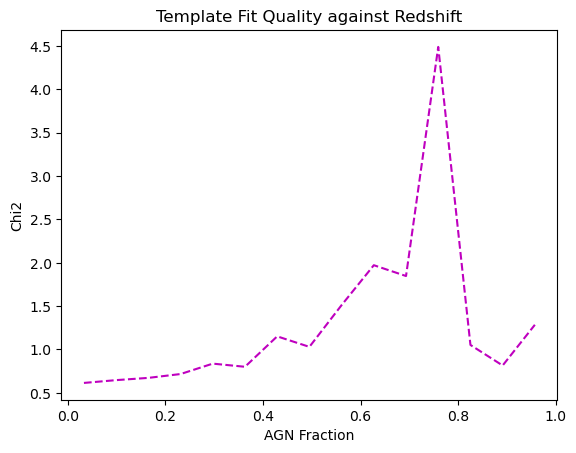

In [102]:
#chi2 against redshift

last_val = 0 # last val is the first value within a bin (say object 2334), while new val is the last
chi2_agn = []
for bin in range(no_of_bins):
    new_val = last_val + counts_agn[bin]-1
    chi2_mean = np.median(main_agn['chi2'][last_val:new_val])
    chi2_agn.append(chi2_mean)
    last_val = new_val + 1
print(f'Fits: {chi2_agn}')

plt.clf()
plt.plot(bin_centers_agn, chi2_agn, 'm--')

plt.xlabel('AGN Fraction')
plt.ylabel('Chi2')


plt.title('Template Fit Quality against Redshift')

plt.savefig(f'outputs/{field}/{test_title}/chi2AGN_{field}_{id_key}_{params["Z_STEP"]}_{agn_sed}_{use_galaxy_templates}.png')
plt.show()

Saving Key data to csv and h5

In [37]:
key_data = pd.DataFrame(columns=headings)
key_data.loc[0] = [id_key, params['Z_STEP'], loop_number, agn_sed, use_galaxy_templates, total_count, mean_frac, spec_count, outliers_count, total_nmad]
key_data.to_csv(key_data_file, mode='a', index=False, header=False)

In [38]:
eazy.hdf5.write_hdf5(self, h5file=output_directory + '.h5')

h5: create file outputs/cdfs/test_3/cdfs_test_3_normal_[]_True.h5
h5: cat/flux_columns
h5: cat/err_columns
h5: cat/f_numbers
h5: cat/fnu
h5: cat/efnu_orig
h5: cat/ok_data
h5: cat/zp
h5: cat/ext_corr
h5: cat/ext_redden
h5: cat/pivot
h5: fit/zml
h5: fit/zbest
h5: fit/chi2_fit
h5: fit/coeffs_best
h5: fit/fit_coeffs
h5: templates/eazy_v1.1_sed1.dat
h5: templates/eazy_v1.1_sed2.dat
h5: templates/eazy_v1.1_sed3.dat
h5: templates/eazy_v1.1_sed4.dat
h5: templates/eazy_v1.1_sed5.dat
h5: templates/eazy_v1.1_sed6.dat
h5: templates/eazy_v1.1_sed7.dat
h5: templates/c09_del_8.6_z_0.019_chab_age09.40_av2.0.dat
h5: templates/erb2010_highEW.dat


In [39]:

#that's all folks